# UKC logbook stats & analysis

### Setup

In [1]:
import os
import re
import pandas as pd
import numpy as np
from datetime import date, timedelta
import matplotlib.pyplot as plt
from typing import List

def clean_logbook(df: pd.DataFrame) -> pd.DataFrame:
    """
    Cleans a climbing logbook DataFrame:
    - Splits 'Grade' and 'Stars' from the 'Grading' column.
    - Parses the 'Date' column into datetime format.
    """
    df = df.rename(columns={'Grade': 'Grading'}, errors='ignore')
    if 'Grading' in df.columns:
        df[['Grade', 'Stars']] = df['Grading'].str.split(' ', n=1, expand=True)
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'], format='%d/%b/%y', errors='coerce')
    return df

def load_logbook(path: str) -> pd.DataFrame:
    """
    Loads and cleans a user's logbook, adding a 'user' column.
    """
    user = path.split('/')[-1].split('_')[0]
    df = pd.read_excel(path)
    df = clean_logbook(df)
    df['user'] = user
    return df

def filter_sport_climbs(df: pd.DataFrame) -> pd.DataFrame:
    """
    Filters the DataFrame to include only clean sport climbs.
    """
    valid_styles = ~df['Style'].isin(['Lead dog', 'Lead dnf', 'TR dnf', 'TR dog'])
    return df[(df['Grade Type'] == 'Sport') & valid_styles]

def filter_boulder_climbs(df: pd.DataFrame) -> pd.DataFrame:
    valid_styles = ~df['Style'].isin(['Sent dnf'])
    return df[(df['Grade Type'] == 'Bouldering') & valid_styles]

def plot_grade_histogram(df: pd.DataFrame, grade_order: List[str]) -> None:
    """
    Plots a grouped histogram of climb counts by grade and user.
    """
    counts = df.groupby(['Grade', 'user']).size().unstack(fill_value=0)
    counts = counts.reindex(grade_order).fillna(0)

    counts.plot(kind='bar', figsize=(12, 6), edgecolor='black', color=['skyblue', 'salmon', 'mediumseagreen', 'goldenrod'])
    plt.title("Climbing Grades Histogram")
    plt.xlabel("Grade")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.legend(title="Climber")
    plt.tight_layout()
    plt.show()

# Define grade order
sport_grade_order = [
    '3a', '3b', '3c',
    '4a', '4b', '4c',
    '5a', '5b', '5c',
    '6a', '6a+', '6b', '6b+', '6c', '6c+',
    '7a', '7a+', '7b', '7b+'
]

bouldering_grade_order = [
    'f3', 'f3+', 
    'f4', 'f4+', 
    'f5', 'f5+', 
    'f6A', 'f6A+', 'f6B', 'f6B+', 'f6C', 'f6C+', 
    'f7A', 'f7A+', 'f7B', 'f7B+'
]

Download logbooks as excel file from UKC

In [2]:
# Load and process logbooks
ad_logbook = load_logbook('./Alistair Duff_Logbook.xlsx')
mp_logbook = load_logbook('./LocquaciousWolf_Logbook.xlsx')
db_logbook = load_logbook('./DanBrown_Logbook.xlsx')
gb_logbook = load_logbook('./Guy B_Logbook.xlsx')

Add additional boulders from 27crags

In [3]:
# Popov's:

# Step 1: Create a DataFrame from the new data
new_data = [
    {"Name": "Moroccan Vibe", "Grade": "6A+", "Type": "Boulder", "Location": "The Bakery", "Stars": "★★", "Date": None, "Style": None},
    {"Name": "Moroccan Melon Patch", "Grade": "3+", "Type": "Boulder", "Location": "The Bakery", "Stars": None, "Date": None, "Style": None},
    {"Name": "Tarte Tartain", "Grade": "6B", "Type": "Boulder", "Location": "The Bakery", "Stars": "★", "Date": None, "Style": None},
    {"Name": "White 11", "Grade": "6A+", "Type": "Boulder", "Location": "The Bakery", "Stars": None, "Date": None, "Style": None},
    {"Name": "White 4", "Grade": "3+", "Type": "Boulder", "Location": "The Bakery", "Stars": None, "Date": None, "Style": None},
    {"Name": "White 1", "Grade": "3+", "Type": "Boulder", "Location": "The Bakery", "Stars": None, "Date": None, "Style": None},
    {"Name": "White 2", "Grade": "5", "Type": "Boulder", "Location": "The Bakery", "Stars": None, "Date": None, "Style": None},
    {"Name": "3X3=6", "Grade": "3", "Type": "Boulder", "Location": "The Bakery", "Stars": None, "Date": None, "Style": None},
    {"Name": "Ham and Cheese Toastie", "Grade": "6A+", "Type": "Boulder", "Location": "The Bakery", "Stars": "★★", "Date": None, "Style": None},
    {"Name": "Tuna Smelt", "Grade": "6B", "Type": "Boulder", "Location": "The Bakery", "Stars": "★", "Date": None, "Style": None},
    {"Name": "Circle Back", "Grade": "6A", "Type": "Boulder", "Location": "Dar", "Stars": "★", "Date": None, "Style": None},
    {"Name": "Skullbeans", "Grade": "5+", "Type": "Boulder", "Location": "Dar", "Stars": None, "Date": None, "Style": None},
    {"Name": "Bucket Bean", "Grade": "5+", "Type": "Boulder", "Location": "Dar", "Stars": None, "Date": None, "Style": None},
    {"Name": "Moroccan Beans", "Grade": "5+", "Type": "Boulder", "Location": "Dar", "Stars": None, "Date": None, "Style": None},
    {"Name": "Shinzo Sasageyo - Direct", "Grade": "6A", "Type": "Boulder", "Location": "Dar", "Stars": "★", "Date": None, "Style": None},
    {"Name": "Shinzo Sasageyo", "Grade": "6A+", "Type": "Boulder", "Location": "Dar", "Stars": "★★", "Date": None, "Style": None},
    {"Name": "Moroccan Cave", "Grade": "6A+", "Type": "Boulder", "Location": "The Bakery", "Stars": "★", "Date": None, "Style": None},
    {"Name": "Clock Work Orange", "Grade": "6A", "Type": "Boulder", "Location": "Backyard", "Stars": "★", "Date": "2025-05-06", "Style": "Redpoint"},
    {"Name": "Dutch Work Orange", "Grade": "6B", "Type": "Boulder", "Location": "Backyard", "Stars": "★", "Date": "2025-05-06", "Style": "Redpoint"},
    {"Name": "Less Trouble", "Grade": "6C", "Type": "Boulder", "Location": "Backyard", "Stars": "★", "Date": "2025-05-06", "Style": "Redpoint"},
    {"Name": "The Arête", "Grade": "6A", "Type": "Boulder", "Location": "Backyard", "Stars": "★", "Date": "2025-05-06", "Style": "Flash"},
    {"Name": "White 3", "Grade": "4", "Type": "Boulder", "Location": "The Bakery", "Stars": "★", "Date": "2025-05-05", "Style": "Flash"},
    {"Name": "I hated every second of it!", "Grade": "6A", "Type": "Boulder", "Location": "The Bakery", "Stars": "★", "Date": "2025-05-05", "Style": "Flash"},
    {"Name": "Traverse of the Wonky Donkey", "Grade": "5+", "Type": "Boulder", "Location": "Plato", "Stars": "★", "Date": "2025-05-05", "Style": "Flash"},
    {"Name": "Coming back to Jesus", "Grade": "4+", "Type": "Boulder", "Location": "Plato", "Stars": "★", "Date": "2025-05-05", "Style": "Flash"},
    {"Name": "Nitrogen", "Grade": "6B", "Type": "Boulder", "Location": "Backyard", "Stars": "★", "Date": "2025-05-05", "Style": "Redpoint"},
]

# Step 2: Create and process DataFrame
new_df = pd.DataFrame(new_data)
new_df['Grade'] = 'f' + new_df['Grade'].str.upper()
new_df['Type'] = 'Bouldering'
new_df['user'] = 'LocquaciousWolf'
new_df = new_df.rename(columns={'Type': 'Grade Type'})
new_df['Date'] = pd.to_datetime(new_df['Date'], errors='coerce')

# Step 3: Append to mp_logbook
mp_logbook = pd.concat([mp_logbook, new_df], ignore_index=True)

In [4]:
# Dan's:

# Data from the second set of images
new_data = [
    # From 1000040594.jpg
    {"Name": "Moroccan Beans", "Grade": "5+", "Type": "Boulder", "Location": "Dar", 
     "Stars": None, "Date": "2025-05-04", "Style": "Flash", "Comment": None},
    {"Name": "Ad Hominem", "Grade": "7A+", "Type": "Boulder", "Location": "Dar", 
     "Stars": "★", "Date": "2025-05-04", "Style": "Flash", "Comment": None},
    {"Name": "White 11", "Grade": "6A+", "Type": "Boulder", "Location": "The Bakery", 
     "Stars": "★", "Date": "2025-05-03", "Style": "Flash", "Comment": None},
    {"Name": "Moroccan Melon Patch", "Grade": "3+", "Type": "Boulder", "Location": "The Bakery", 
     "Stars": None, "Date": "2025-05-03", "Style": "Flash", "Comment": None},
    {"Name": "3X3=6", "Grade": "3", "Type": "Boulder", "Location": "The Bakery", 
     "Stars": "★", "Date": "2025-05-03", "Style": "Flash", "Comment": None},
    {"Name": "Lizard Skewer", "Grade": "6B+", "Type": "Boulder", "Location": "The Bakery", 
     "Stars": "★", "Date": "2025-05-03", "Style": "Flash", "Comment": "As part of flashing lizard kebab"},
    {"Name": "Lizard Kebab", "Grade": "6C", "Type": "Boulder", "Location": "The Bakery", 
     "Stars": "★", "Date": None, "Style": None, "Comment": "Fun movement but a tad soft..."},
    {"Name": "Tuna Smelt", "Grade": "6B", "Type": "Boulder", "Location": "The Bakery", 
     "Stars": "★", "Date": None, "Style": None, "Comment": None},
    {"Name": "Grind", "Grade": "7A", "Type": "Boulder", "Location": "The Bakery", 
     "Stars": "★", "Date": None, "Style": None, "Comment": "Sent on the second attempt"},
    
    # From 1000040596.jpg
    {"Name": "Shinzo Sasageyo - Direct", "Grade": "6A", "Type": "Boulder", "Location": "Dar", 
     "Stars": None, "Date": "2025-05-04", "Style": "Flash", "Comment": None},
    {"Name": "Shinzo Sasageyo", "Grade": "6A+", "Type": "Boulder", "Location": "Dar", 
     "Stars": None, "Date": "2025-05-04", "Style": "Flash", "Comment": None},
    {"Name": "Skullbeans", "Grade": "5+", "Type": "Boulder", "Location": "Dar", 
     "Stars": None, "Date": "2025-05-04", "Style": "Flash", "Comment": None},
    {"Name": "Bucket Bean", "Grade": "5+", "Type": "Boulder", "Location": "Dar", 
     "Stars": None, "Date": "2025-05-04", "Style": "Flash", "Comment": None},
    
    # From 1000040598.jpg
    {"Name": "White 1", "Grade": "3+", "Type": "Boulder", "Location": "The Bakery", 
     "Stars": None, "Date": "2025-05-05", "Style": "Flash", "Comment": None},
    {"Name": "Ham and Cheese Toastie", "Grade": "6A+", "Type": "Boulder", "Location": "The Bakery", 
     "Stars": None, "Date": "2025-05-05", "Style": "Flash", "Comment": "lovely boulder"},
    {"Name": "Knew You Would", "Grade": "7A", "Type": "Boulder", "Location": "Backyard", 
     "Stars": None, "Date": "2025-05-05", "Style": "Flash", "Comment": "Great problem with technical and powerful moves. maybe I should've made finals afterall..."},
    {"Name": "Dutch Work Orange", "Grade": "6B", "Type": "Boulder", "Location": "Backyard", 
     "Stars": None, "Date": "2025-05-05", "Style": "Redpoint", "Comment": None},
    {"Name": "All the Hooks", "Grade": "7A", "Type": "Boulder", "Location": "Backyard", 
     "Stars": None, "Date": "2025-05-05", "Style": "Redpoint", "Comment": "Fun but not particularly natural line"},
    {"Name": "Noir de Noir", "Grade": "6A+", "Type": "Boulder", "Location": "The Bakery", 
     "Stars": None, "Date": "2025-05-04", "Style": "Redpoint", "Comment": None},
]

# Step 2: Create and process DataFrame
new_df = pd.DataFrame(new_data)
new_df['Grade'] = 'f' + new_df['Grade'].str.upper()
new_df['Type'] = 'Bouldering'
new_df['user'] = 'DanBrown'
new_df = new_df.rename(columns={'Type': 'Grade Type'})
new_df['Date'] = pd.to_datetime(new_df['Date'], errors='coerce')

# Step 3: Append to mp_logbook
mp_logbook = pd.concat([mp_logbook, new_df], ignore_index=True)

# Combine data
df = pd.concat([ad_logbook, mp_logbook, db_logbook, gb_logbook], ignore_index=True)

### Sport Climbs

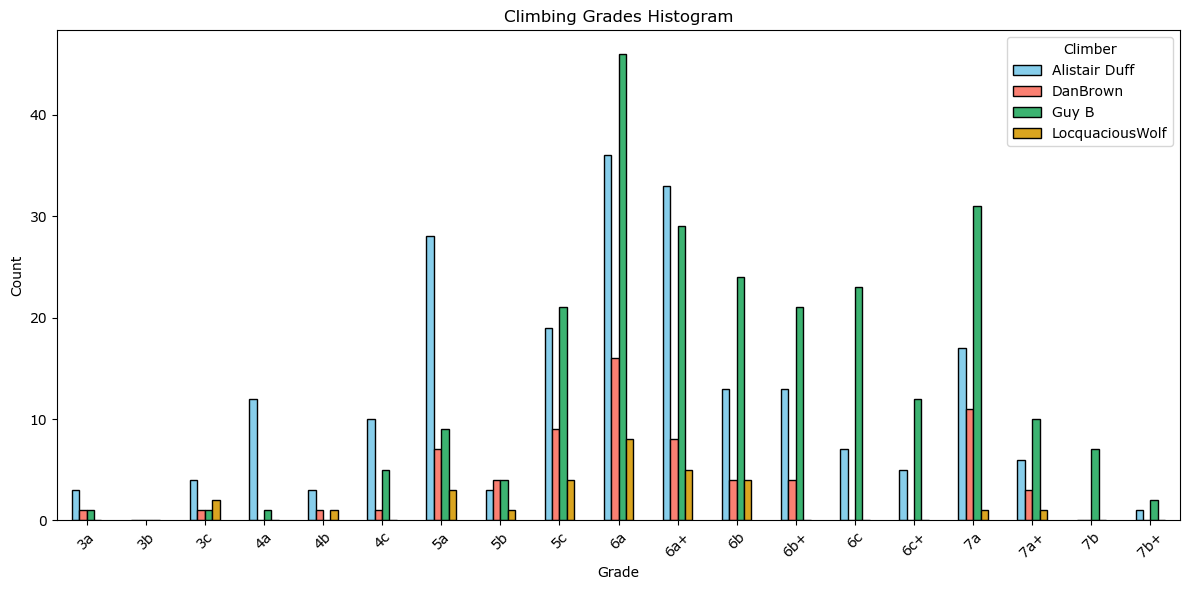

In [5]:
# filter data
sport_log = filter_sport_climbs(df)

# Plot
plot_grade_histogram(sport_log, sport_grade_order)

### Bouldering

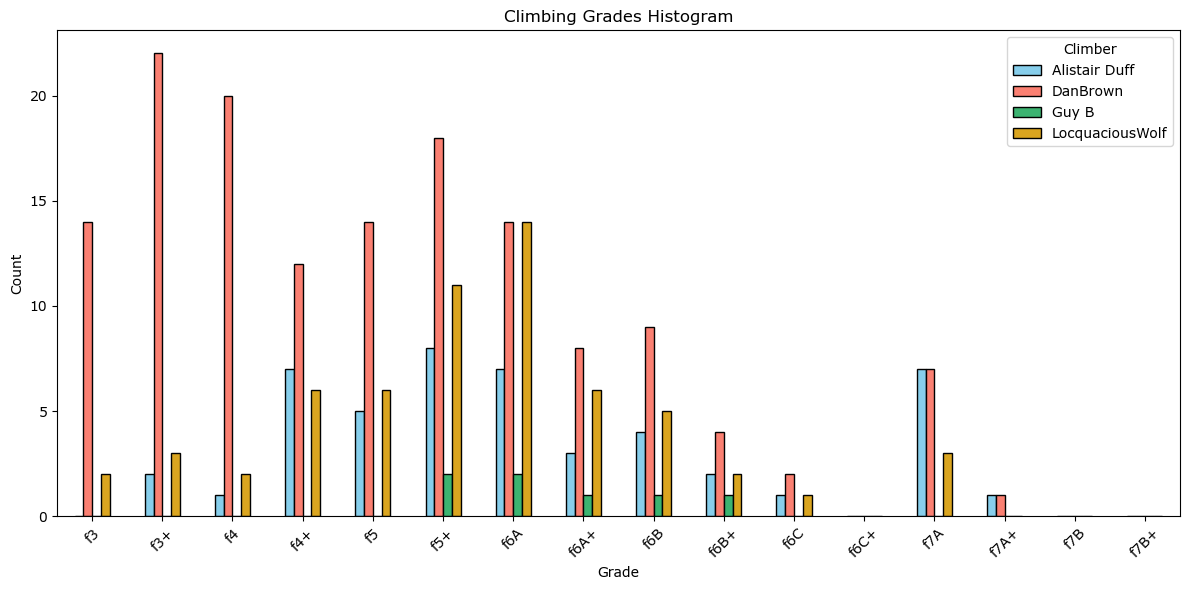

In [6]:
# Combine and filter data
boulder_log = filter_boulder_climbs(df)

# Plot
plot_grade_histogram(boulder_log, bouldering_grade_order)

In [7]:
df['Year'] = df['Date'].dt.year
df_year = df.dropna(subset=['Year'])
climb_counts = df_year.groupby(['user', 'Year']).size().unstack(fill_value=0)



Climb name  Grading  Style  Partner(s)  Notes  \
Date       user                                                             
2014-02-16 Guy B                     4        4      4           0      0   
2014-03-15 Guy B                     3        3      3           0      0   
2014-03-29 Guy B                     5        5      5           0      0   
2014-03-30 Guy B                     2        2      2           0      0   
2014-05-14 Guy B                     6        6      6           0      1   
...                                ...      ...    ...         ...    ...   
2025-05-04 DanBrown                  0        0      7           0      0   
2025-05-05 Alistair Duff             1        1      1           1      1   
           DanBrown                  0        0      5           0      0   
           LocquaciousWolf           0        0      5           0      0   
2025-05-06 LocquaciousWolf           0        0      4           0      0   

                            Crag name  Grade Type  Grade System  Country  \
Date       user                                                            
2014-02-16 Guy B                    4           4             4        4   
2014-03-15 Guy B                    3           3             3        3   
2014-03-29 Guy B                    5           5             5        5   
2014-03-30 Guy B                    2           2             2        2   
2014-05-14 Guy B                    6           6             6        6   
...                               ...         ...           ...      ...   
2025-05-04 DanBrown                 0           7             0        0   
2025-05-05 Alistair Duff            1           1             1        1   
           DanBrown                 0           5             0        0   
           LocquaciousWolf          0           5             0        0   
2025-05-06 LocquaciousWolf          0           4             0        0   

                            Grade  Stars  Name  Location  Comment  
Date       user                                                    
2014-02-16 Guy B                4      4     0         0        0  
2014-03-15 Guy B                3      3     0         0        0  
2014-03-29 Guy B                5      5     0         0        0  
2014-03-30 Guy B                2      2     0         0        0  
2014-05-14 Guy B                6      6     0         0        0  
...                           ...    ...   ...       ...      ...  
2025-05-04 DanBrown             7      1     7         7        0  
2025-05-05 Alistair Duff        1      1     0         0        0  
           DanBrown             5      0     5         5        3  
           LocquaciousWolf      5      5     5         5        0  
2025-05-06 LocquaciousWolf      4      4     4         4        0  

[319 rows x 14 columns]